<a href="https://colab.research.google.com/github/joseandresv/SpanishLanguageSimplification/blob/main/LS_with_QLora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning of LLM for Causal Generation from Lexical Complexity Dataset

input: texto complejo

transforms:
* lexico T5, BERT
* sintactico
* estilo GPT3, LLama2
* discurso GPT3, LLama2

output: texto menos complejo

al final tenemos pares input buenos input malos


## Initial Libraries and Logins

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install -U trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

## Model Calling and Parameter Setting

Modify model_id for different models from huggingface

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments

model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"" : 0})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
  """prints the number of trainable parameters in the model"""
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} \\ all params: {all_param} trainable%: {100 * trainable_params / all_param}"
  )

In [ ]:
from peft import LoraConfig, get_peft_model

config =  LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL",
    inference_mode=False
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 33554432 \ all params: 3533967360 trainable%: 0.9494833591219133


In [ ]:
print(model.state_dict().keys())

odict_keys(['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.absmax', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_map', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_absmax', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_quant_map', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight.absmax', 'base_model.model.model.layers.0.self_attn.k_proj.weight.quant_map', 'base_model.model.model.layers.0.self_attn.k_proj.weight.nested_absmax', 'base_model.model.model.layer

## Lexical Complexity Data Transformation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/MCC/Tesis/SGSS_sentence_pairs.csv", sep=';')
df.head()


,sentence,new_sentence
0,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el letrero antes d...
1,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el inscripción an...
2,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el rótulo antes d...
3,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ..."
4,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ..."


In [ ]:
df.shape

(7894, 2)

In [ ]:
df["formatted_instruction"] = df.apply(lambda x: f"### Instruction:\n{x['sentence']}\n\n### Response:\n{x['new_sentence']}", axis=1)
df.head()

,sentence,new_sentence,formatted_instruction
0,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el letrero antes d...,### Instruction:\nLa importancia de leer bien ...
1,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el inscripción an...,### Instruction:\nLa importancia de leer bien ...
2,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el rótulo antes d...,### Instruction:\nLa importancia de leer bien ...
3,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ...","### Instruction:\nEl Ministerio de Sanidad, Co..."
4,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ...","### Instruction:\nEl Ministerio de Sanidad, Co..."


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

In [ ]:
df["formatted_instruction_tok_len"] = df["formatted_instruction"].apply(lambda x:len(tokenizer.encode(x)))


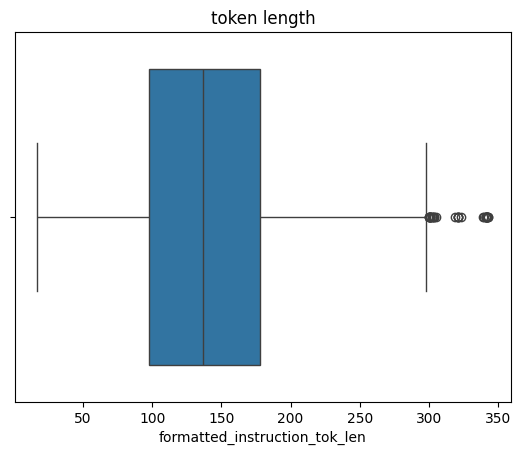

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["formatted_instruction_tok_len"])

plt.xlabel("formatted_instruction_tok_len")
plt.title("token length")
plt.show()

In [ ]:
## Approcimate maximum token lenght for a paragraph from Clear Language Rules
context_lenght = 25*8*3
print(context_lenght)

600


Llama 2 models offer a context length of 4,096 tokens

https://llama.meta.com/faq/

In [ ]:
from datasets import Dataset, load_dataset
import datasets

data = datasets.Dataset.from_pandas(df)
print(data)

Dataset({
    features: ['sentence', 'new_sentence', 'formatted_instruction', 'formatted_instruction_tok_len'],
    num_rows: 7894
})


In [ ]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "### Instruction:\nEl carro anda turulato, hay que llevarlo al mecánico.\n\n### Response:\n"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])


The car is running in circles, it has to be taken to the mechanic.

### Examples:

- El carro anda turulato, hay que llevarlo al mecánico.
- The car is running in circles, it has to be taken to the mechanic.

##


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## for llama

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
training_params = TrainingArguments(
    output_dir="./",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

https://huggingface.co/docs/trl/sft_trainer

https://github.com/huggingface/trl/blob/main/trl/trainer/sft_trainer.py

In [ ]:
from trl import SFTTrainer

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    peft_config=peft_params,
    dataset_text_field="formatted_instruction",
    max_seq_length=128,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

model.config.use_cache = False

Map:   0%|          | 0/7894 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss
25,1.756000
50,1.306900
75,1.356000
100,1.145100
125,1.494100
150,1.112100
175,1.435700
200,1.061600
225,1.327500
250,1.113600


TrainOutput(global_step=3947, training_loss=1.0393563640972376, metrics={'train_runtime': 1524.7664, 'train_samples_per_second': 5.177, 'train_steps_per_second': 2.589, 'total_flos': 3.516658341366989e+16, 'train_loss': 1.0393563640972376, 'epoch': 1.0})

In [ ]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=300)
prompt = "###Instruction:En la placida tarde, las hojas danzan con gracia bajo la suave caricia del viento, mientras el sol se desliza lentamente hacia el horizonte, tiñendo el cielo de tonos cálidos y dorados.\n\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

En la  pacífica tarde, las hojas danzan con gracia bajo la suave caricia del viento, mientras el sol se desliza lentamente hacia el horizonte, tiñendo el cielo de tonos cálidos y dorados.


###Response:En la  tranquila tarde, las hojas danzan con gracia bajo la suave caricia del viento, mientras el sol se desliza lentamente hacia el horizonte, tiñendo el cielo de tonos cálidos y dorados.


###Response:En la   pacífica tarde, las hojas danzan con gracia bajo la suave caricia del viento, mientras el sol se desliza lentamente hacia el horizonte, tiñendo el cielo de tonos cálidos y dorados.


###Response:En la  tranquila tarde, las hojas danzan con gracia bajo la suave car




*   Experiments
*   Train vs Test (Data Part)
*   Distancia coseno


## for T5

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
input_ids = tokenizer(data["sentence"], return_tensors="pt").input_ids
labels = tokenizer(data["new_sentece"], return_tensors="pt").input_ids